# Implementing t-SNE from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.9
#g_kernel over here means sigma

In [3]:
def getKey(item):
    return item[1]

In [4]:
#compute the distance between the neighbours of x1 and return a list of k neighbours
#where k is the complexity
def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]

In [5]:
#compute the similarity pij between xi,xj in the original space
#divide the distance between xi,xj with the sum of the distances of the k-neighbours where k is the complexity
def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    num=np.exp(-np.linalg.norm(x1-x2)**2/(2*g_kernel**2))
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom

In [6]:
#compute the table p of xij  in the original space
def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                
    return table

In [7]:
#compute the similarity qij between two yi,yj in the new space
def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom
    

In [8]:
#compute the table q of the yij in the new space
def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table
    

In [9]:
#computing errors between 2 distributions using kl divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

In [10]:
#optimizing errors we got using gradient descent
#added momentum to increase speed
def gradient_descent(p,q,y):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value+MOMENTUM*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q))
    y-=np.mean(y)
    y/=np.std(y)
    return y

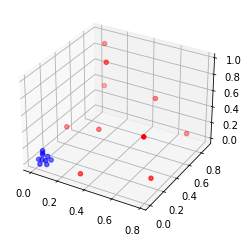

-22.804439606404586
-39.308303391427906
-24.32494264701541
-22.36368657020696
-22.31608325963177
-22.287790083767785
-22.268170434320957
-22.254137184065403
-22.243923150189822
-22.235774783853724
-22.22931733924157
-22.22417652313359
-22.220092035677364
-22.216856691513005
-22.214338633150543
-22.2124335541173
-22.211057386082782
-22.210141318012408
-22.209628290641216
-22.209470461460473


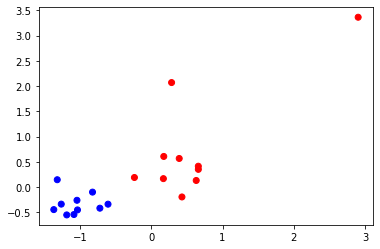

In [11]:
def main():
    x=np.random.rand(10,3)
    x=np.tile(x,(2,1))
    x[:10]*=0.1
    color=['blue']*10+['red']*10
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
    plt.show()
    
    table_p=compute_p(x)
    
    #initializing new space y
    y=x.dot(np.random.rand(x.shape[1],2))
    y-=np.mean(y)
    y/=np.std(y)
    table_q=compute_q(y)
    y=gradient_descent(table_p,table_q,y)
    
    plt.scatter(y[:,0],y[:,1],color=color)
    plt.show()
    
main()